# Method 8 - Best Minus Rest Fresh Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Managers with Best Fresh Ideas

fresh_idea_mgrs = valid_data.merge(flat_qty).merge(flat_pos_size)
fresh_idea_mgrs = fresh_idea_mgrs[fresh_idea_mgrs['pos_rank'] == 1][['datadate', 'institution_id']].drop_duplicates()
fresh_idea_mgrs['fresh'] = 1

# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] == 1].copy()
long_ideas = long_ideas.merge(fresh_idea_mgrs, on=['datadate', 'institution_id'], how='inner')
                                                                                         
short_ideas = valid_data[valid_data['pos_rank'] != 1].copy()
short_ideas = short_ideas.merge(fresh_idea_mgrs, on=['datadate', 'institution_id'], how='inner')

# Weight the best ideas equally

long_ideas['target'] = 1 / long_ideas.groupby('datadate')[
    'institution_id'].transform('count')

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

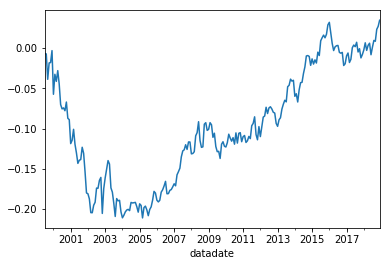

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31   -0.003170
2000-12-31   -0.086018
2001-12-31   -0.099969
2002-12-31    0.006535
2003-12-31   -0.034993
2004-12-31   -0.000377
2005-12-31    0.029747
2006-12-31    0.009370
2007-12-31    0.067368
2008-12-31    0.016331
2009-12-31   -0.021945
2010-12-31    0.006452
2011-12-31    0.021209
2012-12-31    0.004383
2013-12-31    0.059149
2014-12-31    0.019303
2015-12-31    0.051440
2016-12-31   -0.047028
2017-12-31    0.011739
2018-12-31    0.042925
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     25.33
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.19e-17
Time:                        06:40:00   Log-Likelihood:                 731.66
No. Observations:                 234   AIC:                            -1453.
Df Residuals:                     229   BIC:                            -1436.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.460      0.646      -0.001       0.002
mktrf         -0.0240      0.020     -1.197      0.233      -0.063       0.015
me            -0.0717      0.023     -3.079      0.002      -0.118      -0.026
ia            -0.1772      0.035     -5.008      0.000      -0.247      -0.107
roe            0.1713      0.030      5.657      0.000       0.112       0.231
==============================================================================
Omnibus:                       19.939   Durbin-Watson:                   2.314
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.473
Skew:                          -0.439   Prob(JB):                     4.42e-09
Kurtosis:                       4.782   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     12.40
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.80e-09
Time:                        06:40:00   Log-Likelihood:                 731.66
No. Observations:                 234   AIC:                            -1453.
Df Residuals:                     229   BIC:                            -1436.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.466      0.641      -0.001       0.002
mktrf         -0.0240      0.020     -1.195      0.232      -0.063       0.015
me            -0.0717      0.049     -1.473      0.141      -0.167       0.024
ia            -0.1772      0.065     -2.736      0.006      -0.304      -0.050
roe            0.1713      0.042      4.124      0.000       0.090       0.253
==============================================================================
Omnibus:                       19.939   Durbin-Watson:                   2.314
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.473
Skew:                          -0.439   Prob(JB):                     4.42e-09
Kurtosis:                       4.782   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     9.835
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.33e-07
Time:                        06:40:00   Log-Likelihood:                 731.66
No. Observations:                 234   AIC:                            -1453.
Df Residuals:                     229   BIC:                            -1436.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.391      0.696      -0.001       0.002
mktrf         -0.0240      0.020     -1.218      0.223      -0.062       0.015
me            -0.0717      0.048     -1.506      0.132      -0.165       0.022
ia            -0.1772      0.059     -2.986      0.003      -0.293      -0.061
roe            0.1713      0.043      3.983      0.000       0.087       0.256
==============================================================================
Omnibus:                       19.939   Durbin-Watson:                   2.314
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.473
Skew:                          -0.439   Prob(JB):                     4.42e-09
Kurtosis:                       4.782   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     14.90
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.18e-12
Time:                        06:40:00   Log-Likelihood:                 721.88
No. Observations:                 234   AIC:                            -1432.
Df Residuals:                     228   BIC:                            -1411.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.309      0.192      -0.001       0.003
mktrf         -0.0643      0.021     -3.067      0.002      -0.106      -0.023
smb           -0.1049      0.028     -3.795      0.000      -0.159      -0.050
hml           -0.0339      0.033     -1.039      0.300      -0.098       0.030
rmw            0.0619      0.037      1.679      0.095      -0.011       0.134
cma           -0.1299      0.047     -2.773      0.006      -0.222      -0.038
==============================================================================
Omnibus:                       29.454   Durbin-Watson:                   2.380
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.171
Skew:                          -0.415   Prob(JB):                     1.45e-23
Kurtosis:                       6.177   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     15.18
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.14e-13
Time:                        06:40:00   Log-Likelihood:                 721.88
No. Observations:                 234   AIC:                            -1432.
Df Residuals:                     228   BIC:                            -1411.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.697      0.090      -0.000       0.002
mktrf         -0.0643      0.021     -3.008      0.003      -0.106      -0.022
smb           -0.1049      0.042     -2.490      0.013      -0.187      -0.022
hml           -0.0339      0.030     -1.132      0.258      -0.092       0.025
rmw            0.0619      0.060      1.036      0.300      -0.055       0.179
cma           -0.1299      0.077     -1.695      0.090      -0.280       0.020
==============================================================================
Omnibus:                       29.454   Durbin-Watson:                   2.380
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.171
Skew:                          -0.415   Prob(JB):                     1.45e-23
Kurtosis:                       6.177   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     19.54
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.45e-16
Time:                        06:40:00   Log-Likelihood:                 721.88
No. Observations:                 234   AIC:                            -1432.
Df Residuals:                     228   BIC:                            -1411.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.588      0.112      -0.000       0.002
mktrf         -0.0643      0.022     -2.935      0.003      -0.107      -0.021
smb           -0.1049      0.037     -2.865      0.004      -0.177      -0.033
hml           -0.0339      0.026     -1.316      0.188      -0.084       0.017
rmw            0.0619      0.063      0.988      0.323      -0.061       0.185
cma           -0.1299      0.081     -1.601      0.109      -0.289       0.029
==============================================================================
Omnibus:                       29.454   Durbin-Watson:                   2.380
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.171
Skew:                          -0.415   Prob(JB):                     1.45e-23
Kurtosis:                       6.177   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     31.53
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.35e-21
Time:                        06:40:00   Log-Likelihood:                 740.13
No. Observations:                 234   AIC:                            -1470.
Df Residuals:                     229   BIC:                            -1453.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.546      0.586      -0.001       0.002
mktrf         -0.0120      0.018     -0.674      0.501      -0.047       0.023
smb           -0.1653      0.022     -7.455      0.000      -0.209      -0.122
hml           -0.0678      0.022     -3.077      0.002      -0.111      -0.024
umd            0.1045      0.014      7.231      0.000       0.076       0.133
==============================================================================
Omnibus:                       31.882   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.427
Skew:                          -0.535   Prob(JB):                     1.15e-21
Kurtosis:                       5.957   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     13.92
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.53e-10
Time:                        06:40:00   Log-Likelihood:                 740.13
No. Observations:                 234   AIC:                            -1470.
Df Residuals:                     229   BIC:                            -1453.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.546      0.585      -0.001       0.002
mktrf         -0.0120      0.016     -0.767      0.443      -0.043       0.019
smb           -0.1653      0.028     -5.992      0.000      -0.219      -0.111
hml           -0.0678      0.020     -3.318      0.001      -0.108      -0.028
umd            0.1045      0.024      4.353      0.000       0.057       0.152
==============================================================================
Omnibus:                       31.882   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.427
Skew:                          -0.535   Prob(JB):                     1.15e-21
Kurtosis:                       5.957   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     21.27
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.28e-15
Time:                        06:40:00   Log-Likelihood:                 740.13
No. Observations:                 234   AIC:                            -1470.
Df Residuals:                     229   BIC:                            -1453.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.478      0.632      -0.001       0.002
mktrf         -0.0120      0.017     -0.715      0.475      -0.045       0.021
smb           -0.1653      0.023     -7.181      0.000      -0.210      -0.120
hml           -0.0678      0.021     -3.197      0.001      -0.109      -0.026
umd            0.1045      0.022      4.744      0.000       0.061       0.148
==============================================================================
Omnibus:                       31.882   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.427
Skew:                          -0.535   Prob(JB):                     1.15e-21
Kurtosis:                       5.957   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     15.73
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.71e-10
Time:                        06:40:00   Log-Likelihood:                 358.00
No. Observations:                 120   AIC:                            -706.0
Df Residuals:                     115   BIC:                            -692.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.001     -1.022      0.309      -0.004       0.001
mktrf         -0.0095      0.032     -0.296      0.768      -0.073       0.054
me            -0.0296      0.032     -0.929      0.355      -0.093       0.033
ia            -0.2234      0.050     -4.478      0.000      -0.322      -0.125
roe            0.2320      0.044      5.255      0.000       0.145       0.319
==============================================================================
Omnibus:                        5.403   Durbin-Watson:                   2.308
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                5.105
Skew:                          -0.371   Prob(JB):                       0.0779
Kurtosis:                       3.685   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     11.49
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.99e-08
Time:                        06:40:00   Log-Likelihood:                 358.00
No. Observations:                 120   AIC:                            -706.0
Df Residuals:                     115   BIC:                            -692.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.001     -0.957      0.339      -0.004       0.001
mktrf         -0.0095      0.030     -0.313      0.755      -0.069       0.050
me            -0.0296      0.056     -0.527      0.599      -0.140       0.081
ia            -0.2234      0.078     -2.857      0.004      -0.377      -0.070
roe            0.2320      0.052      4.497      0.000       0.131       0.333
==============================================================================
Omnibus:                        5.403   Durbin-Watson:                   2.308
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                5.105
Skew:                          -0.371   Prob(JB):                       0.0779
Kurtosis:                       3.685   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     11.64
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.70e-08
Time:                        06:40:00   Log-Likelihood:                 358.00
No. Observations:                 120   AIC:                            -706.0
Df Residuals:                     115   BIC:                            -692.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.002     -0.815      0.415      -0.004       0.002
mktrf         -0.0095      0.028     -0.335      0.738      -0.065       0.046
me            -0.0296      0.056     -0.531      0.595      -0.139       0.080
ia            -0.2234      0.068     -3.274      0.001      -0.357      -0.090
roe            0.2320      0.048      4.812      0.000       0.138       0.327
==============================================================================
Omnibus:                        5.403   Durbin-Watson:                   2.308
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                5.105
Skew:                          -0.371   Prob(JB):                       0.0779
Kurtosis:                       3.685   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     6.951
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.06e-05
Time:                        06:40:00   Log-Likelihood:                 347.78
No. Observations:                 120   AIC:                            -683.6
Df Residuals:                     114   BIC:                            -666.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.261      0.795      -0.003       0.002
mktrf         -0.0908      0.037     -2.443      0.016      -0.165      -0.017
smb           -0.0719      0.042     -1.708      0.090      -0.155       0.012
hml           -0.0315      0.052     -0.611      0.543      -0.134       0.071
rmw            0.0735      0.061      1.208      0.230      -0.047       0.194
cma           -0.1624      0.067     -2.436      0.016      -0.295      -0.030
==============================================================================
Omnibus:                        9.948   Durbin-Watson:                   2.459
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               16.773
Skew:                          -0.335   Prob(JB):                     0.000228
Kurtosis:                       4.705   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     7.223
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.58e-06
Time:                        06:40:00   Log-Likelihood:                 347.78
No. Observations:                 120   AIC:                            -683.6
Df Residuals:                     114   BIC:                            -666.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.343      0.731      -0.002       0.002
mktrf         -0.0908      0.032     -2.829      0.005      -0.154      -0.028
smb           -0.0719      0.054     -1.339      0.181      -0.177       0.033
hml           -0.0315      0.043     -0.740      0.459      -0.115       0.052
rmw            0.0735      0.078      0.947      0.344      -0.079       0.226
cma           -0.1624      0.087     -1.866      0.062      -0.333       0.008
==============================================================================
Omnibus:                        9.948   Durbin-Watson:                   2.459
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               16.773
Skew:                          -0.335   Prob(JB):                     0.000228
Kurtosis:                       4.705   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     10.36
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.29e-08
Time:                        06:40:00   Log-Likelihood:                 347.78
No. Observations:                 120   AIC:                            -683.6
Df Residuals:                     114   BIC:                            -666.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.304      0.761      -0.003       0.002
mktrf         -0.0908      0.032     -2.796      0.005      -0.155      -0.027
smb           -0.0719      0.046     -1.580      0.114      -0.161       0.017
hml           -0.0315      0.036     -0.874      0.382      -0.102       0.039
rmw            0.0735      0.080      0.917      0.359      -0.084       0.231
cma           -0.1624      0.092     -1.775      0.076      -0.342       0.017
==============================================================================
Omnibus:                        9.948   Durbin-Watson:                   2.459
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               16.773
Skew:                          -0.335   Prob(JB):                     0.000228
Kurtosis:                       4.705   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     14.16
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.98e-09
Time:                        06:40:00   Log-Likelihood:                 355.85
No. Observations:                 120   AIC:                            -701.7
Df Residuals:                     115   BIC:                            -687.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.497      0.620      -0.003       0.002
mktrf         -0.0165      0.029     -0.571      0.569      -0.074       0.041
smb           -0.1561      0.033     -4.738      0.000      -0.221      -0.091
hml           -0.0721      0.033     -2.185      0.031      -0.137      -0.007
umd            0.1045      0.020      5.140      0.000       0.064       0.145
==============================================================================
Omnibus:                       12.128   Durbin-Watson:                   2.240
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               20.119
Skew:                          -0.447   Prob(JB):                     4.28e-05
Kurtosis:                       4.796   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     7.046
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.14e-05
Time:                        06:40:00   Log-Likelihood:                 355.85
No. Observations:                 120   AIC:                            -701.7
Df Residuals:                     115   BIC:                            -687.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.517      0.605      -0.003       0.002
mktrf         -0.0165      0.025     -0.650      0.516      -0.066       0.033
smb           -0.1561      0.035     -4.434      0.000      -0.225      -0.087
hml           -0.0721      0.028     -2.550      0.011      -0.127      -0.017
umd            0.1045      0.029      3.653      0.000       0.048       0.161
==============================================================================
Omnibus:                       12.128   Durbin-Watson:                   2.240
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               20.119
Skew:                          -0.447   Prob(JB):                     4.28e-05
Kurtosis:                       4.796   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     10.88
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.61e-07
Time:                        06:40:00   Log-Likelihood:                 355.85
No. Observations:                 120   AIC:                            -701.7
Df Residuals:                     115   BIC:                            -687.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.452      0.651      -0.003       0.002
mktrf         -0.0165      0.028     -0.600      0.548      -0.070       0.037
smb           -0.1561      0.030     -5.230      0.000      -0.215      -0.098
hml           -0.0721      0.029     -2.514      0.012      -0.128      -0.016
umd            0.1045      0.026      4.023      0.000       0.054       0.155
==============================================================================
Omnibus:                       12.128   Durbin-Watson:                   2.240
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               20.119
Skew:                          -0.447   Prob(JB):                     4.28e-05
Kurtosis:                       4.796   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     13.63
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.80e-09
Time:                        06:40:00   Log-Likelihood:                 394.93
No. Observations:                 114   AIC:                            -779.9
Df Residuals:                     109   BIC:                            -766.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      2.334      0.021       0.000       0.003
mktrf         -0.0253      0.023     -1.112      0.269      -0.070       0.020
me            -0.1718      0.035     -4.888      0.000      -0.242      -0.102
ia            -0.0811      0.049     -1.663      0.099      -0.178       0.016
roe            0.0531      0.043      1.239      0.218      -0.032       0.138
==============================================================================
Omnibus:                        0.230   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.891   Jarque-Bera (JB):                0.326
Skew:                          -0.101   Prob(JB):                        0.850
Kurtosis:                       2.834   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     34.84
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.01e-18
Time:                        06:40:00   Log-Likelihood:                 394.93
No. Observations:                 114   AIC:                            -779.9
Df Residuals:                     109   BIC:                            -766.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.167      0.002       0.001       0.003
mktrf         -0.0253      0.019     -1.309      0.191      -0.063       0.013
me            -0.1718      0.031     -5.617      0.000      -0.232      -0.112
ia            -0.0811      0.046     -1.770      0.077      -0.171       0.009
roe            0.0531      0.039      1.344      0.179      -0.024       0.131
==============================================================================
Omnibus:                        0.230   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.891   Jarque-Bera (JB):                0.326
Skew:                          -0.101   Prob(JB):                        0.850
Kurtosis:                       2.834   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     41.32
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.86e-21
Time:                        06:40:00   Log-Likelihood:                 394.93
No. Observations:                 114   AIC:                            -779.9
Df Residuals:                     109   BIC:                            -766.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.510      0.000       0.001       0.003
mktrf         -0.0253      0.018     -1.427      0.153      -0.060       0.009
me            -0.1718      0.030     -5.785      0.000      -0.230      -0.114
ia            -0.0811      0.049     -1.668      0.095      -0.176       0.014
roe            0.0531      0.039      1.346      0.178      -0.024       0.130
==============================================================================
Omnibus:                        0.230   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.891   Jarque-Bera (JB):                0.326
Skew:                          -0.101   Prob(JB):                        0.850
Kurtosis:                       2.834   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     11.87
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.69e-09
Time:                        06:40:00   Log-Likelihood:                 396.76
No. Observations:                 114   AIC:                            -781.5
Df Residuals:                     108   BIC:                            -765.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.469      0.015       0.000       0.003
mktrf         -0.0300      0.021     -1.397      0.165      -0.073       0.013
smb           -0.1749      0.035     -5.019      0.000      -0.244      -0.106
hml           -0.0301      0.044     -0.678      0.499      -0.118       0.058
rmw            0.0289      0.054      0.531      0.597      -0.079       0.137
cma           -0.0804      0.069     -1.163      0.247      -0.217       0.057
==============================================================================
Omnibus:                        1.143   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.565   Jarque-Bera (JB):                0.862
Skew:                          -0.210   Prob(JB):                        0.650
Kurtosis:                       3.075   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     35.38
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.74e-21
Time:                        06:40:01   Log-Likelihood:                 396.76
No. Observations:                 114   AIC:                            -781.5
Df Residuals:                     108   BIC:                            -765.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.304      0.001       0.001       0.003
mktrf         -0.0300      0.021     -1.448      0.147      -0.071       0.011
smb           -0.1749      0.020     -8.570      0.000      -0.215      -0.135
hml           -0.0301      0.038     -0.799      0.424      -0.104       0.044
rmw            0.0289      0.072      0.401      0.689      -0.112       0.170
cma           -0.0804      0.055     -1.454      0.146      -0.189       0.028
==============================================================================
Omnibus:                        1.143   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.565   Jarque-Bera (JB):                0.862
Skew:                          -0.210   Prob(JB):                        0.650
Kurtosis:                       3.075   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     62.61
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.46e-30
Time:                        06:40:01   Log-Likelihood:                 396.76
No. Observations:                 114   AIC:                            -781.5
Df Residuals:                     108   BIC:                            -765.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      3.987      0.000       0.001       0.003
mktrf         -0.0300      0.019     -1.548      0.122      -0.068       0.008
smb           -0.1749      0.018     -9.478      0.000      -0.211      -0.139
hml           -0.0301      0.038     -0.798      0.425      -0.104       0.044
rmw            0.0289      0.074      0.392      0.695      -0.116       0.173
cma           -0.0804      0.048     -1.678      0.093      -0.174       0.013
==============================================================================
Omnibus:                        1.143   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.565   Jarque-Bera (JB):                0.862
Skew:                          -0.210   Prob(JB):                        0.650
Kurtosis:                       3.075   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     21.23
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.75e-13
Time:                        06:40:01   Log-Likelihood:                 404.64
No. Observations:                 114   AIC:                            -799.3
Df Residuals:                     109   BIC:                            -785.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.034      0.044    3.66e-05       0.003
mktrf         -0.0164      0.020     -0.830      0.409      -0.056       0.023
smb           -0.1895      0.031     -6.134      0.000      -0.251      -0.128
hml           -0.0342      0.032     -1.076      0.284      -0.097       0.029
umd            0.1031      0.024      4.295      0.000       0.056       0.151
==============================================================================
Omnibus:                        1.066   Durbin-Watson:                   2.146
Prob(Omnibus):                  0.587   Jarque-Bera (JB):                0.704
Skew:                          -0.177   Prob(JB):                        0.703
Kurtosis:                       3.153   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     58.34
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.11e-26
Time:                        06:40:01   Log-Likelihood:                 404.64
No. Observations:                 114   AIC:                            -799.3
Df Residuals:                     109   BIC:                            -785.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.659      0.008       0.000       0.002
mktrf         -0.0164      0.015     -1.119      0.263      -0.045       0.012
smb           -0.1895      0.027     -7.004      0.000      -0.243      -0.136
hml           -0.0342      0.027     -1.254      0.210      -0.088       0.019
umd            0.1031      0.017      6.214      0.000       0.071       0.136
==============================================================================
Omnibus:                        1.066   Durbin-Watson:                   2.146
Prob(Omnibus):                  0.587   Jarque-Bera (JB):                0.704
Skew:                          -0.177   Prob(JB):                        0.703
Kurtosis:                       3.153   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     52.82
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.14e-24
Time:                        06:40:01   Log-Likelihood:                 404.64
No. Observations:                 114   AIC:                            -799.3
Df Residuals:                     109   BIC:                            -785.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000      2.918      0.004       0.000       0.002
mktrf         -0.0164      0.012     -1.363      0.173      -0.040       0.007
smb           -0.1895      0.029     -6.474      0.000      -0.247      -0.132
hml           -0.0342      0.026     -1.302      0.193      -0.086       0.017
umd            0.1031      0.014      7.278      0.000       0.075       0.131
==============================================================================
Omnibus:                        1.066   Durbin-Watson:                   2.146
Prob(Omnibus):                  0.587   Jarque-Bera (JB):                0.704
Skew:                          -0.177   Prob(JB):                        0.703
Kurtosis:                       3.153   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""